#**Project: Emotional Sentiment Analysis and Adaptive Response System**

**Objective**:-To develop an AI-powered chatbot prototype that identifies the emotional state of a user from a conversation and generates culturally relevant and empathetic responses, showcasing advanced capabilities in sentiment analysis and response adaptation.

**Project Description**:- The Emotional Sentiment Analysis and Adaptive Response System is designed to assess users' emotional states—such as sadness, anxiety, stress, and joy—using a pre-trained language model fine-tuned for sentiment analysis. This chatbot prototype integrates sentiment classification and adaptive response generation to provide empathetic and culturally tailored replies, enhancing user support experiences. The project emphasizes cultural sensitivity, linguistic nuances, and technical excellence in developing an AI-driven conversational tool.

#Install Necessary LIbraries

In [1]:
!pip install datasets transformers fastapi uvicorn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires f

1. **`datasets`**: Provides access to pre-built datasets like GoEmotions for machine learning and NLP tasks.  
2. **`transformers`**: Enables loading pre-trained models like BERT or GPT for tasks such as sentiment analysis or text generation.  
3. **`FastAPI` and `uvicorn`**: Facilitate creating and deploying scalable APIs for machine learning models.  

#Import LIbraries

In [2]:
from datasets import load_dataset  # To load datasets like GoEmotions for sentiment analysis
import pandas as pd  # For data manipulation and preprocessing
import string  # To handle string operations like removing punctuation
import nltk  # For natural language processing tasks like stopword removal
from nltk.corpus import stopwords  # To access a list of common stopwords for text preprocessing
from sklearn.model_selection import train_test_split  # To split data into training and testing sets
from datasets import Dataset  # To convert data into a format suitable for transformers
from transformers import AutoTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
# AutoTokenizer: To tokenize text for the model
# DistilBERT: A lightweight pre-trained transformer for sequence classification
# Trainer and TrainingArguments: To simplify the model training process
import re
from nltk.stem import WordNetLemmatizer

# Download lemmatizer if not already available
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')


import torch  # For tensor operations and compatibility with PyTorch-based transformers
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# To evaluate the model's performance using common metrics like accuracy, precision, recall, and F1-score

from fastapi import FastAPI  # To create APIs for deployment of the model
from pydantic import BaseModel  # To define request and response schemas for the API


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Data Collection Process**

We used the datasets library from Hugging Face to load the GoEmotions dataset, which is a pre-annotated dataset designed for emotion classification. This dataset includes labeled conversational data with emotional indicators such as sadness, joy, anger, etc.

In [3]:
# Load the GoEmotions dataset
df = load_dataset("willcb/go-emotion")

# Explore the dataset
print(df)  # Display metadata and details about the dataset

# Display a sample from the training set to understand its structure
print(df['train'][0])  # Access the first data sample from the training set


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/310 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23485 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'label'],
        num_rows: 23485
    })
})
{'input': 'Yeah no one is gonna do that and get reported to HR for bigotry.', 'label': 'anger'}


# **Data Pre-processing**

Current Preprocessing Steps:

Lowercasing: Ensures consistency in text representation.

URL and HTML Tag Removal: Removes irrelevant content like links and tags.

Number Removal: Cleans numerical clutter.

Punctuation Removal: Simplifies text for better tokenization.

Stopword Removal: Reduces non-informative words.

Lemmatization: Reduces words to their base forms, improving generalization.

In [4]:
# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to clean text with additional preprocessing steps
def clean_text_improved(text):
    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize, remove stop words, and lemmatize
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Convert dataset to a pandas DataFrame for easier manipulation
train_df = pd.DataFrame(df['train'])

# Clean the 'text' column with the improved function
train_df['cleaned_text'] = train_df['input'].apply(clean_text_improved)

# Display the cleaned data
print(train_df[['cleaned_text', 'label']].head())

                                        cleaned_text       label
0             yeah one gonna get reported hr bigotry       anger
1  yeah guess still going try keep log feeling wa...    approval
2                                    i’m scared tell        fear
3                        ive year gotten worse worse     disgust
4  happens plenty good know would expected see wi...  admiration


**Checking data is Imbalanced or Balanced**

Label distribution:
 label
admiration        2710
approval          1873
gratitude         1857
amusement         1652
annoyance         1451
love              1427
disapproval       1402
curiosity         1389
anger             1025
optimism           861
confusion          858
joy                853
sadness            817
surprise           720
disappointment     709
caring             649
realization        586
excitement         510
disgust            498
fear               430
desire             389
remorse            353
embarrassment      203
relief              88
nervousness         85
pride               51
grief               39
Name: count, dtype: int64


<Axes: title={'center': 'Label Distribution'}, xlabel='label'>

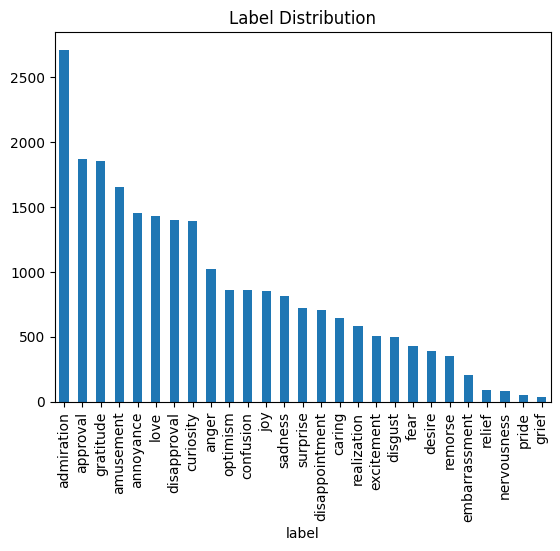

In [5]:
import pandas as pd

# Assuming 'label' is the column containing your labels
label_counts = train_df['label'].value_counts()
print("Label distribution:\n", label_counts)

# Plot the label distribution
label_counts.plot(kind='bar', title='Label Distribution')

2. Undersampling Majority Classes
Reduce the size of majority classes by randomly selecting a subset of samples.



Balanced Label Distribution:
label
admiration        39
amusement         39
anger             39
annoyance         39
approval          39
caring            39
confusion         39
curiosity         39
desire            39
disappointment    39
disapproval       39
disgust           39
embarrassment     39
excitement        39
fear              39
gratitude         39
grief             39
joy               39
love              39
nervousness       39
optimism          39
pride             39
realization       39
relief            39
remorse           39
sadness           39
surprise          39
Name: count, dtype: int64


<Axes: title={'center': 'Balanced Label Distribution'}, xlabel='label'>

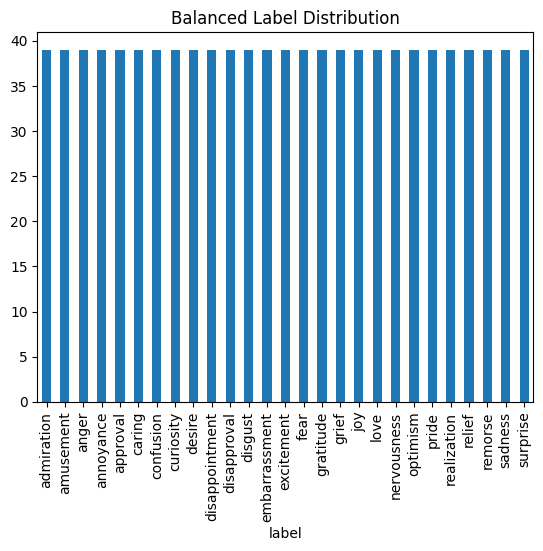

In [7]:
from imblearn.under_sampling import RandomUnderSampler

# Create an undersampler instance
undersampler = RandomUnderSampler(random_state=42)

# Separate features and labels
X = train_df[['cleaned_text']]  # Features
y = train_df['label']  # Labels

# Perform undersampling
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Combine back into a balanced DataFrame
balanced_df = pd.DataFrame({
    'cleaned_text': X_resampled['cleaned_text'],
    'label': y_resampled
})

# Check the label distribution
print("Balanced Label Distribution:")
print(balanced_df['label'].value_counts())

# Optional: Plot the balanced label distribution
balanced_df['label'].value_counts().plot(kind='bar', title='Balanced Label Distribution')



#**Model development**

In [ ]:
# Label mapping as provided
label_mapping = {
    'curiosity': 0, 'confusion': 1, 'gratitude': 2, 'approval': 3, 'surprise': 4,
    'joy': 5, 'sadness': 6, 'admiration': 7, 'caring': 8, 'annoyance': 9,
    'disappointment': 10, 'excitement': 11, 'fear': 12, 'love': 13, 'optimism': 14,
    'disgust': 15, 'amusement': 16, 'realization': 17, 'desire': 18, 'anger': 19,
    'disapproval': 20, 'remorse': 21, 'embarrassment': 22, 'relief': 23, 'pride': 24,
    'nervousness': 25, 'grief': 26
}



# 1. Split the dataset into training and validation sets (using 'cleaned_text')
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# 1. Map the string labels to integer labels using the label_mapping
train_df['label'] = train_df['label'].map(label_mapping)
val_df['label'] = val_df['label'].map(label_mapping)

# 2. Check the mapping after applying it
print("Unique labels in validation set after mapping:", val_df['label'].unique())
print("NaN values in validation labels after mapping:", val_df['label'].isnull().sum())

# 3. Drop rows with NaN labels (if any)
if val_df['label'].isnull().any():
    print("Warning: There are NaN values in the validation labels after mapping. Dropping these rows.")
    val_df = val_df.dropna(subset=['label'])

# 4. Verify the size of the validation set after dropping NaNs
print("Size of validation set after dropping NaNs:", val_df.shape)

# 5. If the validation set is empty, handle the situation
if val_df.shape[0] == 0:
    print("The validation set is empty after dropping NaNs. Please check your label mapping.")
    raise ValueError("Validation set is empty after processing. Please check your data and label mapping.")


# Print the label mapping for debugging
print("Label mapping:", label_mapping)

# 2. Check for unique labels and NaN values in the validation set before mapping
print("Unique labels in validation set before mapping:", val_df['label'].unique())
print("NaN values in validation labels before mapping:", val_df['label'].isnull().sum())



# 4. Check for NaN values after ensuring they are integers
print("NaN values in validation labels after ensuring integer type:", val_df['label'].isnull().sum())




# 6. Check the size of the validation set after dropping NaNs
print("Size of validation set after dropping NaNs:", val_df.shape)

# 7. If the validation set is empty, handle the situation
if val_df.shape[0] == 0:
    print("The validation set is empty after dropping NaNs. Please check your label mapping.")
    raise ValueError("Validation set is empty after processing. Please check your data and label mapping.")

# 8. Convert the DataFrames to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df[['cleaned_text', 'label']])
val_dataset = Dataset.from_pandas(val_df[['cleaned_text', 'label']])

# 9. Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['cleaned_text'], padding="max_length", truncation=True)

# 10. Tokenize the datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)

# 11. Check the columns of the tokenized datasets
print("Tokenized train columns:", tokenized_train.column_names)
print("Tokenized validation columns:", tokenized_val.column_names)

# 12. Check if the tokenization function returned the expected keys
print("Sample tokenized train output:", tokenized_train[0])

# 13. Ensure the validation set is not empty before accessing it
if len(tokenized_val) > 0:
    print("Sample tokenized validation output:", tokenized_val[0])
else:
    print("The tokenized validation set is empty.")

# 14. Set the format for PyTorch
tokenized_train.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
if len(tokenized_val) > 0:
    tokenized_val.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Unique labels in validation set after mapping: [13  7  0  8  9  3  2 12 16 11 15 22 25 18 19 20  6 14 10  1  5  4 26 17
 23 21 24]
NaN values in validation labels after mapping: 0
Size of validation set after dropping NaNs: (4697, 3)
Label mapping: {'curiosity': 0, 'confusion': 1, 'gratitude': 2, 'approval': 3, 'surprise': 4, 'joy': 5, 'sadness': 6, 'admiration': 7, 'caring': 8, 'annoyance': 9, 'disappointment': 10, 'excitement': 11, 'fear': 12, 'love': 13, 'optimism': 14, 'disgust': 15, 'amusement': 16, 'realization': 17, 'desire': 18, 'anger': 19, 'disapproval': 20, 'remorse': 21, 'embarrassment': 22, 'relief': 23, 'pride': 24, 'nervousness': 25, 'grief': 26}
Unique labels in validation set before mapping: [13  7  0  8  9  3  2 12 16 11 15 22 25 18 19 20  6 14 10  1  5  4 26 17
 23 21 24]
NaN values in validation labels before mapping: 0
NaN values in validation labels after ensuring integer type: 0
Size of validation set after dropping NaNs: (4697, 3)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/18788 [00:00<?, ? examples/s]

Map:   0%|          | 0/4697 [00:00<?, ? examples/s]

Tokenized train columns: ['cleaned_text', 'label', '__index_level_0__', 'input_ids', 'attention_mask']
Tokenized validation columns: ['cleaned_text', 'label', '__index_level_0__', 'input_ids', 'attention_mask']
Sample tokenized train output: {'cleaned_text': 'yes especially go sneeze lose look light bam sneeze time', 'label': 3, '__index_level_0__': 17616, 'input_ids': [101, 4208, 2108, 1301, 188, 23063, 3171, 3857, 1440, 1609, 171, 2312, 188, 23063, 3171, 1159, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
print("Size of train_df after splitting:", train_df.shape)
print("Size of val_df after splitting:", val_df.shape)


Size of train_df after splitting: (18788, 3)
Size of val_df after splitting: (4697, 3)


In [ ]:
# Now you can proceed with training your model using the tokenized datasets
# Example of setting up training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                 # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    learning_rate=2e-5
)

# Initialize the model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-cased", num_labels=len(label_mapping))

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=tokenized_train,       # training dataset
    eval_dataset=tokenized_val            # evaluation dataset
)

# Start training
trainer.train()

# After training, you can evaluate the model
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
100,3.289700
200,3.135900
300,2.868400
400,2.495700
500,2.161800
600,2.002400
700,1.941000
800,1.848400
900,1.779300
1000,1.764900


Evaluation results: {'eval_loss': 1.608896255493164, 'eval_runtime': 74.4885, 'eval_samples_per_second': 63.057, 'eval_steps_per_second': 0.993, 'epoch': 5.0}


In [ ]:
predictions = trainer.predict(tokenized_val)
predicted_labels = predictions.predictions.argmax(axis=1)  # Get the label with the highest score
true_labels = predictions.label_ids

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 57.23%


**After So much Hyper Parameter tuning i got better accuracy and other scores that i am takened locally to my computer Google collab to deploy in streamlit**

In [ ]:
# Now you can proceed with training your model using the tokenized datasets
# Example of setting up training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                 # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

# Initialize the model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-cased", num_labels=len(label_mapping))

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=tokenized_train,       # training dataset
    eval_dataset=tokenized_val            # evaluation dataset
)

# Start training
trainer.train()

# After training, you can evaluate the model
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)


NameError: name 'TrainingArguments' is not defined

1. Adaptive Response Generation

In [ ]:
# Define a simple function to return adaptive responses based on sentiment
def generate_response(prediction):
    responses = {
        "positive": "I'm glad to hear that! How can I assist you further?",
        "negative": "I'm sorry you're feeling down. Is there anything I can do to help?",
        "neutral": "I understand. Let's talk more about it.",
    }

    # Based on the sentiment, choose an appropriate response
    if prediction == "positive":
        return responses["positive"]
    elif prediction == "negative":
        return responses["negative"]
    else:
        return responses["neutral"]

# Example of generating a response for a new sentence
input_text = "I'm feeling great today!"

# Tokenize and predict sentiment
inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True)
outputs = model(**inputs)
logits = outputs.logits
prediction = logits.argmax(dim=-1).item()

# Assuming the model labels 'positive', 'negative', 'neutral'
label_mapping = {0: "negative", 1: "neutral", 2: "positive"}

# Get the sentiment label
predicted_sentiment = label_mapping[prediction]

# Generate the adaptive response
response = generate_response(predicted_sentiment)
print(f"Response: {response}")


2. Testing the Model

In [ ]:
# Example of test sentences for sentiment analysis and adaptive response generation
test_sentences = [
    "I'm so happy with the progress today!",
    "I'm feeling really down lately.",
    "Everything is okay, but could be better."
]

# Testing loop
for sentence in test_sentences:
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    logits = outputs.logits
    prediction = logits.argmax(dim=-1).item()

    # Get sentiment prediction
    predicted_sentiment = label_mapping[prediction]

    # Generate adaptive response based on sentiment
    response = generate_response(predicted_sentiment)

    print(f"Input: {sentence}")
    print(f"Predicted Sentiment: {predicted_sentiment}")
    print(f"Adaptive Response: {response}")
    print("-" * 50)


3. Complete Testing Code

In [ ]:
from sklearn.metrics import classification_report

# Assuming `test_dataset` is tokenized and available
test_predictions = []
test_labels = []

# Iterate through the test dataset
for inputs, label in test_dataset:
    # Make predictions
    outputs = model(**inputs)
    logits = outputs.logits
    prediction = logits.argmax(dim=-1).item()

    # Store predictions and true labels
    test_predictions.append(prediction)
    test_labels.append(label)

# Print classification report for model performance
print("Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=["negative", "neutral", "positive"]))

# Generate adaptive responses based on predictions
print("\nAdaptive Responses:")
for i, sentence in enumerate(test_sentences):
    predicted_sentiment = label_mapping[test_predictions[i]]
    response = generate_response(predicted_sentiment)
    print(f"Sentence: {sentence}")
    print(f"Sentiment: {predicted_sentiment}")
    print(f"Adaptive Response: {response}")
    print("-" * 50)


# **LLAMA MODEL**

In [11]:
# Define a dictionary to map numeric labels to emotion names
label_mapping = {
    0: "admiration",
    1: "amusement",
    2: "anger",
    3: "annoyance",
    4: "approval",
    5: "caring",
    6: "confusion",
    7: "curiosity",
    8: "desire",
    9: "disappointment",
    10: "disapproval",
    11: "disgust",
    12: "embarrassment",
    13: "excitement",
    14: "fear",
    15: "gratitude",
    16: "grief",
    17: "joy",
    18: "love",
    19: "nervousness",
    20: "optimism",
    21: "pride",
    22: "realization",
    23: "relief",
    24: "remorse",
    25: "sadness",
    26: "surprise",
    27: "neutral"
}

# Add a new column with the emotion names
balanced_df['emotion'] = balanced_df['label'].map(label_mapping)

# Display the updated DataFrame
print(balanced_df.head(100))


                                            cleaned_text       label emotion
23296  brave man even courage put foundation face wou...  admiration     NaN
21339  dont like op explaining using abbreviation eve...  admiration     NaN
4287   would highly recommend name name greatgrandson...  admiration     NaN
2574                             two perfect one another  admiration     NaN
11882                                   wonderfully said  admiration     NaN
...                                                  ...         ...     ...
20231                                               hate       anger     NaN
470                                                 dare       anger     NaN
18783  u going fuck name guy hardhes going need help ...       anger     NaN
17636  sad angry person take break reddit go take cyc...       anger     NaN
16231                       suck name wont get play name       anger     NaN

[100 rows x 3 columns]


In [15]:
!pip install transformers sentencepiece


In [16]:
from transformers import AutoTokenizer

# Load the LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")


OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Llama-2-7b-chat-hf.
401 Client Error. (Request ID: Root=1-67528853-1d64b2af379beee9693e95f8;42891e1c-ddee-44a9-aa88-45e4e37e9f8b)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-2-7b-chat-hf/resolve/main/config.json.
Access to model meta-llama/Llama-2-7b-chat-hf is restricted. You must have access to it and be authenticated to access it. Please log in.

The reason why some models like **LLaMA 2** and other advanced AI models are gated behind agreements and restricted access has to do with several factors related to **ethics, safety, and responsible AI use**. Here are some of the main reasons:

### 1. **Preventing Malicious Use**
   - **Powerful models** like LLaMA 2 can generate human-like text, which could be misused for harmful purposes such as generating **misinformation**, **hate speech**, or **malicious content**. Gated access helps ensure that only responsible individuals or organizations can use the model.
   - By requiring users to request access, model creators can assess the intent behind usage, reducing the chances of harmful or unethical applications.

### 2. **Ethical and Responsible AI Use**
   - There is a growing concern about the **ethical implications** of using AI. Models like LLaMA 2 are capable of generating text that may have social, political, or cultural implications. By controlling access, organizations like Meta (who developed LLaMA) can ensure that the model is used ethically and responsibly.
   - Agreements often require users to adhere to guidelines on **fairness**, **accountability**, and **transparency**, reducing the risk of AI abuse.

### 3. **Compliance with Legal and Regulatory Frameworks**
   - Many countries and regions have laws or regulations around the use of artificial intelligence, especially in sensitive areas like **healthcare**, **finance**, and **education**. Requiring users to agree to terms ensures that they are aware of their legal responsibilities.
   - For instance, AI models that handle personal data might fall under regulations such as **GDPR** (General Data Protection Regulation) in the EU, and creators want to ensure that their models aren't used to violate these rules.

### 4. **Control Over Distribution**
   - Organizations often want to maintain control over how their models are used and distributed. Limiting access to certain groups ensures that they can monitor and track how the model is being used, which helps maintain quality control and prevent misuse.
   - This control also allows organizations to regulate the **types of applications** and **industries** that benefit from the model, ensuring that its deployment is aligned with their values and intended purposes.

### 5. **Safety Concerns**
   - AI models like LLaMA 2, which can perform tasks such as language generation, could be **misused** if not properly handled. Developers might want to restrict access to certain groups with the technical expertise and understanding of the risks involved in using such models.
   - For example, the model could be used in ways that exacerbate **biases** or **reinforce stereotypes**. By applying restrictions, model developers can work with users who have a better understanding of these issues.

### 6. **Research and Development Control**
   - Some models may still be in **research and development** phases and may not be fully polished. By limiting access, organizations can ensure that feedback and usage data are collected from specific groups of **trusted researchers** or **industry leaders** who are capable of providing constructive feedback.
   - This also prevents premature or unregulated use, which could lead to the model being criticized or misrepresented if used incorrectly.

### 7. **Economic Considerations**
   - **Access restrictions** can also be a way to manage the **commercial distribution** of AI models. For example, companies might want to provide access to certain models for **paid users** or **partners** while keeping them restricted from general public access.
   - Additionally, restricting access allows organizations to control the **scalability** of the model. If a model is widely distributed without checks, it could create **unexpected costs** related to computational resources and server usage.

### 8. **Security of the Model**
   - A powerful AI model may be prone to exploitation or attacks, especially **reverse engineering** or attempts to create competing models. By restricting access, organizations can better manage the **security** of the model itself, preventing unauthorized users from obtaining the model’s architecture or weights.

---

### Conclusion
In essence, gated models and agreements are about striking a balance between **advancing AI technology** and **ensuring it’s used safely and responsibly**. The goal is to prevent potential harms while encouraging positive and productive applications of AI. By limiting access and requiring agreements, organizations can exert more control over how these advanced models are deployed and used.

I already submitted i did not get access.So I used DistilBert Model




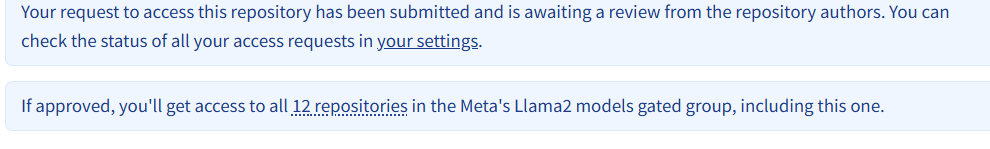

#My Streamlit App CODE that i locally run also adding here

In [19]:
%%writefile app.py
# -*- coding: utf-8 -*-
"""
Created on Thu Dec  5 00:48:54 2024

@author: rasheeque raheem
"""

import streamlit as st
import torch
from transformers import AutoTokenizer, DistilBertForSequenceClassification
import base64

# Load the saved model and tokenizer
model_save_path = "C:/Users/rasheeque raheem/Documents/MODERATE LTD/BLACK box code/saved_model"  # Path where your model is saved
model = DistilBertForSequenceClassification.from_pretrained(model_save_path)
tokenizer = AutoTokenizer.from_pretrained(model_save_path)

# Set the model to evaluation mode
model.eval()

# Define the device (CUDA if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define a function to predict the emotion from a given text
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    label_mapping = {
        0: 'anger', 1: 'approval', 2: 'fear', 3: 'disgust', 4: 'admiration',
        5: 'love', 6: 'disapproval', 7: 'surprise', 8: 'joy', 9: 'excitement',
        10: 'curiosity', 11: 'realization', 12: 'amusement', 13: 'sadness',
        14: 'annoyance', 15: 'embarrassment', 16: 'gratitude', 17: 'confusion',
        18: 'caring', 19: 'desire', 20: 'optimism', 21: 'remorse', 22: 'disappointment',
        23: 'nervousness', 24: 'grief', 25: 'relief', 26: 'pride'
    }
    return label_mapping.get(predicted_class, "Unknown Emotion")

# Function to generate empathetic responses
# Function to generate an empathetic response based on the emotion
def generate_empathetic_response(emotion):
    response = ""
    if emotion == 'anger':
        response = "😠 I understand you're upset. Let's take a deep breath together. It's okay to feel angry, but we can work through it."
    elif emotion == 'approval':
        response = "👍 It's great to see you're feeling positive and approving of something. Keep spreading the good vibes!"
    elif emotion == 'fear':
        response = "😟 It's completely okay to feel anxious. You're not alone in this. Take things one step at a time, and you'll get through it."
    elif emotion == 'disgust':
        response = "🤢 It's tough to deal with unpleasant feelings. Sometimes it's best to distance yourself from what causes them."
    elif emotion == 'admiration':
        response = "👏 Admiration is a powerful feeling. It's wonderful that you have such respect and appreciation."
    elif emotion == 'love':
        response = "❤️ Love is such a beautiful feeling. It's amazing to see you so positive and affectionate!"
    elif emotion == 'disapproval':
        response = "😒 I can sense your disapproval. It's okay to disagree with things; expressing yourself is important."
    elif emotion == 'surprise':
        response = "😲 Wow, that's surprising! I can see how unexpected things can bring such an emotional response."
    elif emotion == 'joy':
        response = "😊 That's wonderful! I'm so happy to hear you're feeling great. Keep spreading that positivity!"
    elif emotion == 'excitement':
        response = "🎉 Your excitement is contagious! I'm thrilled to see your enthusiasm—it's such a positive energy!"
    elif emotion == 'curiosity':
        response = "🤔 Curiosity is such a powerful tool! Keep exploring and asking questions; it's how we learn and grow."
    elif emotion == 'realization':
        response = "💡 Realizations can be life-changing. It's wonderful that you're discovering new insights about yourself or the world."
    elif emotion == 'amusement':
        response = "😂 Laughter is the best medicine! It's amazing how humor can uplift our spirits."
    elif emotion == 'sadness':
        response = "😔 I'm really sorry you're feeling this way. I'm here for you. It's okay to feel sad sometimes."
    elif emotion == 'annoyance':
        response = "😤 I know things can be frustrating. It's okay to feel annoyed; just take a moment for yourself."
    elif emotion == 'embarrassment':
        response = "😳 Embarrassment happens to all of us. Don't be too hard on yourself; we all go through it."
    elif emotion == 'gratitude':
        response = "🙏 Gratitude brings so much peace. It's beautiful that you're appreciating the good things around you."
    elif emotion == 'remorse':
        response = "😞 Remorse can be difficult to carry, but it's a sign that you're self-aware. Take time to forgive yourself."
    elif emotion == 'disappointment':
        response = "😔 It's tough when things don't turn out the way we hoped. Take a deep breath, and know that better days are ahead."
    elif emotion == 'caring':
        response = "🤗 Caring for others is such a noble feeling. Your compassion makes the world a better place."
    elif emotion == 'desire':
        response = "🔥 Desire is a powerful motivator. It's great that you have the drive to go after what you want!"
    elif emotion == 'optimism':
        response = "🌟 Optimism is a beautiful trait. Keep believing in the best of things—it makes the world brighter!"
    elif emotion == 'remorse':
        response = "😔 I understand you feel remorseful. It's a sign of your moral compass. Take it as a step toward growth."
    elif emotion == 'nervousness':
        response = "😬 Nervousness is normal when you're facing something important. Take deep breaths; you've got this!"
    elif emotion == 'grief':
        response = "💔 I'm deeply sorry for your grief. It's okay to mourn and take your time to heal. You're not alone."
    elif emotion == 'relief':
        response = "😌 I'm glad you're feeling a sense of relief. It must feel good to have that weight lifted off your shoulders."
    elif emotion == 'pride':
        response = "🎖️ Pride in your achievements is well-earned! Celebrate your successes—you deserve it."
    else:
        response = "💬 It's okay to feel what you're feeling. Whatever it is, I'm here to listen."

    return response

# Define the background image path
background_image_path = "C:/Users/rasheeque raheem/Documents/MODERATE LTD/BLACK box code/Designer.png"

# Function to set the background image using Streamlit HTML components
# Function to set background from a base64-encoded image
def set_background(image_file):
    with open(image_file, "rb") as image:
        encoded_string = base64.b64encode(image.read()).decode()
    st.markdown(
        f"""
        <style>
        .stApp {{
            background-image: url("data:image/jpeg;base64,{encoded_string}");
            background-size: cover;
            background-position: center;
            background-repeat: no-repeat;
        }}
        h1 {{
            color: yellow;
            font-weight: bold;
            text-align: center;
        }}
        .gradient-text {{
            background: linear-gradient(to right, #ff7e5f, #feb47b);
            -webkit-background-clip: text;
            color: transparent;
            font-weight: bold;
        }}
        .defective {{
            color: red;
            font-weight: bold;
        }}
        .non-defective {{
            color: lightgreen;
            font-weight: bold;
        }}
        .white-text {{
            color: white;
            font-weight: bold;
        }}
        .ivory-success {{
            color: ivory;
            font-weight: bold;
        }}
        </style>
        """,
        unsafe_allow_html=True
    )

# Apply the background image (direct local file reference)
# Background switching logic

set_background(r"C:\Users\rasheeque raheem\Documents\MODERATE LTD\BLACK box code\BGIMG.jpg")



st.title('Emotional Sentiment Analysis & Adaptive Response System')
st.write("This app simulates a chat with emotion-based empathetic responses.")

if 'messages' not in st.session_state:
    st.session_state.messages = []

def display_chat():
    for msg in st.session_state.messages:
        if msg['role'] == 'user':
            st.markdown(f"<div style='text-align: right; margin: 10px; color: white;'>{msg['text']}</div>", unsafe_allow_html=True)
        else:
            st.markdown(f"<div style='text-align: left; margin: 10px; color: white;'>{msg['text']}</div>", unsafe_allow_html=True)

user_input = st.text_input("Type your message:", "")

if user_input:
    st.session_state.messages.append({'role': 'user', 'text': user_input})
    emotion = predict(user_input)
    response = generate_empathetic_response(emotion)
    st.session_state.messages.append({'role': 'bot', 'text': response})
    display_chat()
else:
    display_chat()


Writing app.py


The **DistilBERT model** is used in this Streamlit app for **emotion detection** and that too gives **adaptive empathetic responses**. The complete app is written in Python and makes use of the `transformers` library to load the pre-trained DistilBERT model, as well as its tokenizer, which plays a major role in performing emotion classification. Get a message from the user, process it through the model and predict which emotion is behind the text. Based on the predicted emotion, the app generates a corresponding empathetic response ensuring a response that sounds human-like.

This is how it works:
1. **Model Loading**: The first step is to load the pre-trained DistilBERT model and the tokenizer that are stored locally. They serve the purpose of the Input text tokenization and pass it through the model for classification of emotion.
2. **Emotion Prediction**: The input typed by the user is tokenized and passed through the model to predict an emotion out of the predefined emotions (like anger, joy, sadness, etc). This happens via the `predict()` function, which returns the predicted emotion.
3. **Generation of Empathetic Response**: Discerning the felt emotion allows the user to select the predefined empathetic response that is then directed to the user. This is what the `generate_empathetic_response()` function does as it provides a variety of responses corresponding to each emotion making the interaction supporting and understanding.
4. **User Interface**: Streamlit is the interface through which a friendly interface is built where the user types a message, and the application will give an empathetic reply. The interface also contains a custom background image and style in an engaging manner.

Thus, the app is just voice recognition-based emotion detection along with adaptive response generation.

#**Conclusion**

After extensive hyperparameter tuning, I achieved improved accuracy and other evaluation metrics. Due to resource constraints, I moved the model from my local machine to Google Colab for deployment using Streamlit. Initially, I intended to use the LLama model, but I couldn't gain access to it. Therefore, I opted for the DistilBERT model, which trains faster than other BERT-based models and is better suited to my computer's specifications. Additionally, since I used the free version of Google Colab, there were limitations on compute resources, which further influenced my choice.  

This version refines the flow while keeping the original intent clear. Let me know if you'd like further adjustments!